In [856]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

from collections import Counter 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler





%matplotlib inline

In [857]:
data = pd.read_csv("../data/ADNIMERGE_04Dec2025.csv")
data.columns = [x.lower().strip() for x in data.columns]
selected_columns = ['rid', 'ptid', 'viscode', 'site', 'colprot', 'origprot', 'examdate',
                    'dx_bl', 'age', 'ptgender', 'dx']

adnimerge = data[selected_columns]
adnimerge.head(10)

C:\Users\iraci\AppData\Local\Temp\ipykernel_4296\1397751346.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/ADNIMERGE_04Dec2025.csv")


,rid,ptid,viscode,site,colprot,origprot,examdate,dx_bl,age,ptgender,dx
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,CN
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,Dementia
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,Dementia
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,Dementia
4,3,011_S_0003,m24,11,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,Dementia
5,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,MCI
6,4,022_S_0004,m06,22,ADNI1,ADNI1,2006-05-02,LMCI,67.5,Male,MCI
7,4,022_S_0004,m12,22,ADNI1,ADNI1,2006-11-14,LMCI,67.5,Male,MCI
8,4,022_S_0004,m18,22,ADNI1,ADNI1,2007-05-14,LMCI,67.5,Male,MCI
9,4,022_S_0004,m36,22,ADNI1,ADNI1,2008-11-18,LMCI,67.5,Male,MCI




Vou selecionar apenas os pacientes que começaram o estudo com MCI (EMCI ou LMCI). 
Preciso verificar se há alguma inconsistência entre dx_bl e dx na visita baseline.

In [858]:
diag_baseline_mci = adnimerge[adnimerge["dx_bl"].isin(["EMCI", "LMCI"])]

print(f"Total de registros com dx_bl = EMCI ou LMCI: {len(diag_baseline_mci)}")
print(f"Número único de pacientes (RID): {diag_baseline_mci['rid'].nunique()}")
diag_baseline_mci.head()

Total de registros com dx_bl = EMCI ou LMCI: 8270
Número único de pacientes (RID): 1113


,rid,ptid,viscode,site,colprot,origprot,examdate,dx_bl,age,ptgender,dx
5,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,MCI
6,4,022_S_0004,m06,22,ADNI1,ADNI1,2006-05-02,LMCI,67.5,Male,MCI
7,4,022_S_0004,m12,22,ADNI1,ADNI1,2006-11-14,LMCI,67.5,Male,MCI
8,4,022_S_0004,m18,22,ADNI1,ADNI1,2007-05-14,LMCI,67.5,Male,MCI
9,4,022_S_0004,m36,22,ADNI1,ADNI1,2008-11-18,LMCI,67.5,Male,MCI


In [859]:
print("Distribuição dos tipos de MCI:")
print(diag_baseline_mci.groupby('dx_bl')['rid'].nunique())

Distribuição dos tipos de MCI:
dx_bl
EMCI    423
LMCI    690
Name: rid, dtype: int64


In [860]:

casos_inconsistentes = diag_baseline_mci[(diag_baseline_mci["viscode"] == "bl") & 
                                          (diag_baseline_mci["dx"] == "Dementia")]
print(f"Casos com inconsistência (dx_bl=MCI mas dx=Dementia no baseline): {len(casos_inconsistentes)}")
casos_inconsistentes

Casos com inconsistência (dx_bl=MCI mas dx=Dementia no baseline): 6


,rid,ptid,viscode,site,colprot,origprot,examdate,dx_bl,age,ptgender,dx
762,332,021_S_0332,bl,21,ADNI1,ADNI1,2006-04-19,LMCI,69.9,Male,Dementia
2061,995,100_S_0995,bl,100,ADNI1,ADNI1,2006-11-13,LMCI,78.5,Female,Dementia
2364,1154,100_S_1154,bl,100,ADNI1,ADNI1,2007-01-30,LMCI,76.6,Male,Dementia
5295,78,023_S_0078,bl,23,ADNI1,ADNI1,2006-01-12,LMCI,76.0,Female,Dementia
5605,190,100_S_0190,bl,100,ADNI1,ADNI1,2006-05-16,LMCI,78.8,Male,Dementia
7748,1226,100_S_1226,bl,100,ADNI1,ADNI1,2007-02-15,LMCI,82.6,Male,Dementia



Percebi que alguns pacientes têm dx_bl diferente de dx na visita baseline. 

In [861]:
if len(casos_inconsistentes) > 0:
    rids_problematicos = casos_inconsistentes['rid'].unique()
    print(f"RIDs com problema: {rids_problematicos}")
    print(f"\nTotal: {len(rids_problematicos)} pacientes")
else:
    print("Nenhuma inconsistência encontrada!")

RIDs com problema: [ 332  995 1154   78  190 1226]

Total: 6 pacientes


In [862]:
filtro_baseline = ((adnimerge["dx_bl"].isin(["EMCI", "LMCI"])) & 
                   (adnimerge["viscode"] == "bl") & 
                   (adnimerge["dx"] == "MCI"))

pacientes_mci_limpos = adnimerge[filtro_baseline]['rid'].unique()
print(f"Pacientes MCI : {len(pacientes_mci_limpos)}")
pacientes_mci_limpos[:20] 

Pacientes MCI : 1100


array([  4,   6,  38,  42,  45,  51,  54,  57,  60,  77,  80,  87,  98,
       101, 103, 107, 108, 111, 112, 116])

In [863]:
df_mci_completo = adnimerge[adnimerge['rid'].isin(pacientes_mci_limpos)].copy()

print(f"Total de registros: {len(df_mci_completo)}")
print(f"Número de pacientes únicos: {df_mci_completo['rid'].nunique()}")
print(f"\nVisitas disponíveis:")
print(df_mci_completo['viscode'].value_counts().sort_index())

Total de registros: 8211
Número de pacientes únicos: 1100

Visitas disponíveis:
viscode
bl      1100
m03      440
m06      809
m102      48
m108     103
m114      32
m12      934
m120      68
m126      29
m132      45
m138      18
m144      16
m150      10
m156       5
m162       8
m168       5
m174       5
m18      696
m180       4
m186       7
m192       2
m198       4
m24      770
m30      474
m36      646
m42      190
m48      442
m54      129
m60      268
m66      152
m72      193
m78      159
m84      162
m90      107
m96      131
Name: count, dtype: int64


Vou verificar se há dados de ADNI3 e considerar removê-los para manter consistência com outras análises da literatura que focam em ADNI1/2/GO.

In [864]:
print("Distribuição por fase do estudo (COLPROT):")
print(df_mci_completo['colprot'].value_counts())

if 'ADNI3' in df_mci_completo['colprot'].values:
    n_adni3 = (df_mci_completo['colprot'] == 'ADNI3').sum()
    pacientes_adni3 = df_mci_completo[df_mci_completo['colprot'] == 'ADNI3']['rid'].nunique()
    print(f"\nEncontrados {n_adni3} registros de {pacientes_adni3} pacientes da fase ADNI3")
    
    df_mci_completo = df_mci_completo[df_mci_completo['colprot'] != 'ADNI3'].copy()
    
    print(f"\nApós remoção de ADNI3:")
    print(f"  - Total de registros: {len(df_mci_completo)}")
    print(f"  - Pacientes únicos: {df_mci_completo['rid'].nunique()}")
else:
    print("\nNenhum registro ADNI3 encontrado. Dataset já está restrito a ADNI1/GO/2.")

print(f"\nVisitas disponíveis após filtragem:")
print(df_mci_completo['viscode'].value_counts().sort_index())

Distribuição por fase do estudo (COLPROT):
colprot
ADNI2     3833
ADNI1     2504
ADNI3     1269
ADNIGO     605
Name: count, dtype: int64

Encontrados 1269 registros de 428 pacientes da fase ADNI3

Após remoção de ADNI3:
  - Total de registros: 6942
  - Pacientes únicos: 865

Visitas disponíveis após filtragem:
viscode
bl      865
m03     440
m06     809
m102      2
m108     58
m114      2
m12     788
m120     25
m126      2
m132      1
m18     687
m24     689
m30     452
m36     591
m42     179
m48     409
m54     113
m60     236
m66     114
m72     137
m78     108
m84      97
m90      56
m96      82
Name: count, dtype: int64


In [865]:
df_mci_completo.head(20)

,rid,ptid,viscode,site,colprot,origprot,examdate,dx_bl,age,ptgender,dx
5,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,MCI
6,4,022_S_0004,m06,22,ADNI1,ADNI1,2006-05-02,LMCI,67.5,Male,MCI
7,4,022_S_0004,m12,22,ADNI1,ADNI1,2006-11-14,LMCI,67.5,Male,MCI
8,4,022_S_0004,m18,22,ADNI1,ADNI1,2007-05-14,LMCI,67.5,Male,MCI
9,4,022_S_0004,m36,22,ADNI1,ADNI1,2008-11-18,LMCI,67.5,Male,MCI
15,6,100_S_0006,bl,100,ADNI1,ADNI1,2005-11-29,LMCI,80.4,Female,MCI
16,6,100_S_0006,m06,100,ADNI1,ADNI1,2006-06-01,LMCI,80.4,Female,MCI
17,6,100_S_0006,m12,100,ADNI1,ADNI1,2006-11-20,LMCI,80.4,Female,MCI
18,6,100_S_0006,m18,100,ADNI1,ADNI1,2007-05-15,LMCI,80.4,Female,MCI
19,6,100_S_0006,m36,100,ADNI1,ADNI1,2008-12-08,LMCI,80.4,Female,MCI


In [866]:
pacientes_com_m36 = df_mci_completo[df_mci_completo['viscode'] == 'm36']['rid'].unique()
print(f"Pacientes com visita m36: {len(pacientes_com_m36)}")
print(f"Pacientes perdidos: {len(pacientes_mci_limpos) - len(pacientes_com_m36)}")

Pacientes com visita m36: 591
Pacientes perdidos: 509



Antes de continuar, vou verificar se há pacientes que começaram normais e converteram para demência.

In [867]:
pacientes_cn_baseline = adnimerge[adnimerge['dx_bl'] == 'CN']['rid'].unique()
print(f"Pacientes com dx_bl = CN (Normal): {len(pacientes_cn_baseline)}")

df_cn = adnimerge[adnimerge['rid'].isin(pacientes_cn_baseline)].copy()

cn_para_dementia = df_cn[df_cn['dx'] == 'Dementia']['rid'].unique()
print(f"Pacientes CN que converteram para Dementia: {len(cn_para_dementia)}")

cn_para_mci = df_cn[df_cn['dx'] == 'MCI']['rid'].unique()
print(f"Pacientes CN que converteram para MCI: {len(cn_para_mci)}")

if len(cn_para_dementia) > 0:
    print(f"\nExemplo de trajetória CN -> Dementia (RID {cn_para_dementia[0]}):")
    exemplo = df_cn[df_cn['rid'] == cn_para_dementia[0]][['viscode', 'dx', 'age', 'dx_bl']].head(10)
    print(exemplo)

Pacientes com dx_bl = CN (Normal): 542
Pacientes CN que converteram para Dementia: 33
Pacientes CN que converteram para MCI: 105

Exemplo de trajetória CN -> Dementia (RID 223):
     viscode        dx   age dx_bl
521       bl        CN  78.0    CN
522      m06       MCI  78.0    CN
523      m12       MCI  78.0    CN
524      m24       MCI  78.0    CN
525      m36  Dementia  78.0    CN
5667     m18       NaN  78.0    CN
5668     m30       NaN  78.0    CN


### Definindo as visitas de interesse

Visitas: bl, m03, m06, m12, m18, m24, m30, m36
Vou focar no período de 3 anos: baseline até m36.

In [868]:
visitas_interesse = ['bl', 'm03', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36']

df_mci_3anos = df_mci_completo[
    (df_mci_completo['rid'].isin(pacientes_com_m36)) & 
    (df_mci_completo['viscode'].isin(visitas_interesse))
].copy()

print(f"  - Pacientes: {df_mci_3anos['rid'].nunique()}")
print(f"  - Registros totais: {len(df_mci_3anos)}")
print(f"  - Média de visitas por paciente: {len(df_mci_3anos) / df_mci_3anos['rid'].nunique():.1f}")

  - Pacientes: 591
  - Registros totais: 4179
  - Média de visitas por paciente: 7.1



Um paciente é considerado "conversor" se em qualquer visita durante os 3 anos o dx = "Dementia".
Agora preciso verificar quais pacientes converteram para demência durante os 3 anos de acompanhamento.

In [869]:
print("Diagnósticos encontrados no dataset:")
print(df_mci_3anos['dx'].value_counts())
print(f"\nPacientes que converteram para Dementia em algum momento:")
pacientes_dementia = df_mci_3anos[df_mci_3anos['dx'] == 'Dementia']['rid'].unique()
print(f"  Total: {len(pacientes_dementia)}")

Diagnósticos encontrados no dataset:
dx
MCI         2570
Dementia     472
CN           111
Name: count, dtype: int64

Pacientes que converteram para Dementia em algum momento:
  Total: 192



Vou criar uma função para determinar se cada paciente converteu ou não.

In [870]:
dicionario_conversao = {}

for rid in df_mci_3anos['rid'].unique():
    registros_paciente = df_mci_3anos[df_mci_3anos['rid'] == rid]
    converteu = 'Dementia' in registros_paciente[registros_paciente['viscode'] != 'bl']['dx'].values
    dicionario_conversao[rid] = 'SIM' if converteu else 'NAO'

print(f"Total de conversores: {list(dicionario_conversao.values()).count('SIM')}")
print(f"Total de não-conversores: {list(dicionario_conversao.values()).count('NAO')}")

Total de conversores: 192
Total de não-conversores: 399


In [871]:
df_mci_3anos['converteu_3anos'] = df_mci_3anos['rid'].map(dicionario_conversao)

print("Dataset final com status de conversão:" , df_mci_3anos[['rid', 'viscode', 'dx', 'converteu_3anos']].head(15))


Dataset final com status de conversão:     rid viscode   dx converteu_3anos
5     4      bl  MCI             NAO
6     4     m06  MCI             NAO
7     4     m12  MCI             NAO
8     4     m18  MCI             NAO
9     4     m36  MCI             NAO
15    6      bl  MCI             NAO
16    6     m06  MCI             NAO
17    6     m12  MCI             NAO
18    6     m18  MCI             NAO
19    6     m36  MCI             NAO
55   33     m12  MCI             NAO
56   33     m36  MCI             NAO
68   41     m06  MCI             SIM
69   42      bl  MCI             SIM
70   42     m06  MCI             SIM


In [872]:
df_baseline = df_mci_3anos[df_mci_3anos['viscode'] == 'bl'].copy()
df_baseline = df_baseline.reset_index(drop=True)

print(f"  - Total de pacientes: {len(df_baseline)}")
print(f"  - Conversores: {(df_baseline['converteu_3anos'] == 'SIM').sum()}")
print(f"  - Não-conversores: {(df_baseline['converteu_3anos'] == 'NAO').sum()}")
df_baseline.head(10)

  - Total de pacientes: 591
  - Conversores: 192
  - Não-conversores: 399


,rid,ptid,viscode,site,colprot,origprot,examdate,dx_bl,age,ptgender,dx,converteu_3anos
0,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,MCI,NAO
1,6,100_S_0006,bl,100,ADNI1,ADNI1,2005-11-29,LMCI,80.4,Female,MCI,NAO
2,42,023_S_0042,bl,23,ADNI1,ADNI1,2005-11-10,LMCI,72.8,Male,MCI,SIM
3,51,099_S_0051,bl,99,ADNI1,ADNI1,2005-12-08,LMCI,66.5,Male,MCI,NAO
4,54,099_S_0054,bl,99,ADNI1,ADNI1,2005-12-16,LMCI,81.0,Female,MCI,SIM
5,57,018_S_0057,bl,18,ADNI1,ADNI1,2006-01-06,LMCI,77.3,Male,MCI,SIM
6,77,067_S_0077,bl,67,ADNI1,ADNI1,2006-02-08,LMCI,79.7,Male,MCI,SIM
7,80,018_S_0080,bl,18,ADNI1,ADNI1,2006-01-13,LMCI,85.0,Male,MCI,NAO
8,98,067_S_0098,bl,67,ADNI1,ADNI1,2006-03-29,LMCI,84.4,Female,MCI,SIM
9,101,007_S_0101,bl,7,ADNI1,ADNI1,2006-01-04,LMCI,73.6,Male,MCI,SIM



Vou olhar a trajetória completa de alguns pacientes que converteram e os que nao converteram

In [873]:
if len(pacientes_dementia) > 0:
    exemplo_rid = pacientes_dementia[0]
    print(f"Trajetória do paciente RID {exemplo_rid}:")
    trajetoria = df_mci_3anos[df_mci_3anos['rid'] == exemplo_rid][['viscode', 'dx', 'age', 'converteu_3anos']]
    print(trajetoria)
pacientes_nao_conv = df_baseline[df_baseline['converteu_3anos'] == 'NAO']['rid'].values
if len(pacientes_nao_conv) > 0:
    exemplo_rid_nao_conv = pacientes_nao_conv[0]
    print(f"Trajetória do paciente RID {exemplo_rid_nao_conv} (NÃO-CONVERSOR):")
    trajetoria_nao_conv = df_mci_3anos[df_mci_3anos['rid'] == exemplo_rid_nao_conv][['viscode', 'dx', 'age', 'converteu_3anos']]
    print(trajetoria_nao_conv)

Trajetória do paciente RID 42:
     viscode        dx   age converteu_3anos
69        bl       MCI  72.8             SIM
70       m06       MCI  72.8             SIM
71       m12  Dementia  72.8             SIM
72       m18  Dementia  72.8             SIM
73       m24  Dementia  72.8             SIM
74       m36  Dementia  72.8             SIM
5177     m30       NaN  72.8             SIM
Trajetória do paciente RID 4 (NÃO-CONVERSOR):
     viscode   dx   age converteu_3anos
5         bl  MCI  67.5             NAO
6        m06  MCI  67.5             NAO
7        m12  MCI  67.5             NAO
8        m18  MCI  67.5             NAO
9        m36  MCI  67.5             NAO
5115     m30  NaN  67.5             NAO


In [874]:
print(f"\nPacientes MCI selecionados: {df_baseline['rid'].nunique()}")
print(f"\nDistribuição de conversão:")
print(f"Conversores (SIM): {(df_baseline['converteu_3anos'] == 'SIM').sum()} ({(df_baseline['converteu_3anos'] == 'SIM').sum() / len(df_baseline) * 100:.1f}%)")
print(f"Não-conversores (NAO): {(df_baseline['converteu_3anos'] == 'NAO').sum()} ({(df_baseline['converteu_3anos'] == 'NAO').sum() / len(df_baseline) * 100:.1f}%)")
print("\nDistribuição por gênero:", df_baseline['ptgender'].value_counts())
print(f"\nIdade média: {df_baseline['age'].mean():.1f} anos (DP: {df_baseline['age'].std():.1f})")



Pacientes MCI selecionados: 591

Distribuição de conversão:
Conversores (SIM): 192 (32.5%)
Não-conversores (NAO): 399 (67.5%)

Distribuição por gênero: ptgender
Male      359
Female    232
Name: count, dtype: int64

Idade média: 72.7 anos (DP: 7.5)



Vou salvar os datasets processados 

In [875]:
output_path_completo = "../data/mci_pacientes_3anos_completo.csv"
df_mci_3anos.to_csv(output_path_completo, index=False)
print(f"Dataset completo salvo em: {output_path_completo}")

output_path_baseline = "../data/mci_pacientes_baseline.csv"
df_baseline.to_csv(output_path_baseline, index=False)
print(f"Dataset baseline salvo em: {output_path_baseline}")

Dataset completo salvo em: ../data/mci_pacientes_3anos_completo.csv
Dataset baseline salvo em: ../data/mci_pacientes_baseline.csv



Primeiro preciso entender quais variáveis têm dados faltantes e quanto, pra depois salvar os dados e treinar modelos.

In [876]:
df_ml = df_baseline.copy()

print(f"Dataset para ML: {df_ml.shape}")
print(f"\nColunas disponíveis: {df_ml.columns.tolist()}")

missing_info = pd.DataFrame({
    'coluna': df_ml.columns,
    'missing': df_ml.isnull().sum(),
    'percentual': (df_ml.isnull().sum() / len(df_ml) * 100).round(2)
})

missing_info = missing_info[missing_info['missing'] > 0].sort_values('percentual', ascending=False)

if len(missing_info) > 0:
    print(missing_info.to_string(index=False))
else:
    print("Nenhum valor ausente encontrado!")

Dataset para ML: (591, 12)

Colunas disponíveis: ['rid', 'ptid', 'viscode', 'site', 'colprot', 'origprot', 'examdate', 'dx_bl', 'age', 'ptgender', 'dx', 'converteu_3anos']
Nenhum valor ausente encontrado!



Vou buscar mais variáveis do dataset original que podem ser úteis para o modelo (testes cognitivos, biomarcadores, etc).

In [877]:
features_importantes = [
    'rid', 'viscode', 'age', 'ptgender', 'pteducat',  
    'mmse', 'adas11', 'adas13', 'cdrsb',  
    'ravlt_immediate', 'ravlt_learning', 'ravlt_forgetting', 'ravlt_perc_forgetting',  
    'faq', 'moca',  
    'hippocampus', 'ventricles', 'wholebrain', 'entorhinal', 'fusiform', 'midtemp', 'icv',  
    'abeta', 'tau', 'ptau', 
    'fdg', 'av45',  
    'apoe4'  
]

features_disponiveis = [f for f in features_importantes if f in data.columns]
print(f"Features disponíveis: {len(features_disponiveis)}/{len(features_importantes)}")

data_baseline_ml = data[data['viscode'] == 'bl'][features_disponiveis].copy()

data_baseline_ml = data_baseline_ml[data_baseline_ml['rid'].isin(df_baseline['rid'])]
data_baseline_ml = data_baseline_ml.merge(df_baseline[['rid', 'converteu_3anos']], on='rid', how='left')

print(f"\nDataset para ML: {data_baseline_ml.shape}")
print(f"Colunas: {data_baseline_ml.columns.tolist()}")

Features disponíveis: 28/28

Dataset para ML: (591, 29)
Colunas: ['rid', 'viscode', 'age', 'ptgender', 'pteducat', 'mmse', 'adas11', 'adas13', 'cdrsb', 'ravlt_immediate', 'ravlt_learning', 'ravlt_forgetting', 'ravlt_perc_forgetting', 'faq', 'moca', 'hippocampus', 'ventricles', 'wholebrain', 'entorhinal', 'fusiform', 'midtemp', 'icv', 'abeta', 'tau', 'ptau', 'fdg', 'av45', 'apoe4', 'converteu_3anos']


In [878]:
print("VALORES AUSENTES NO DATASET EXPANDIDO")

missing_expandido = pd.DataFrame({
    'coluna': data_baseline_ml.columns,
    'missing': data_baseline_ml.isnull().sum(),
    'percentual': (data_baseline_ml.isnull().sum() / len(data_baseline_ml) * 100).round(2)
})

missing_expandido = missing_expandido[missing_expandido['missing'] > 0].sort_values('percentual', ascending=False)
print(missing_expandido.to_string(index=False))

VALORES AUSENTES NO DATASET EXPANDIDO
     coluna  missing  percentual
       moca      262       44.33
       av45      262       44.33
      abeta      152       25.72
        tau      152       25.72
       ptau      152       25.72
        fdg      125       21.15
   fusiform       95       16.07
 entorhinal       95       16.07
    midtemp       95       16.07
hippocampus       86       14.55
 ventricles       18        3.05
 wholebrain        8        1.35
     adas13        3        0.51
        faq        3        0.51
        icv        2        0.34
     adas11        1        0.17


In [879]:
features_boas = missing_expandido[missing_expandido['percentual'] < 10]['coluna'].tolist()
features_medias = missing_expandido[(missing_expandido['percentual'] >= 10) & 
                                     (missing_expandido['percentual'] < 50)]['coluna'].tolist()
features_ruins = missing_expandido[missing_expandido['percentual'] >= 50]['coluna'].tolist()

print(f"Features com < 10% missing ({len(features_boas)}): {features_boas}")
print(f"\nFeatures com 10-50% missing ({len(features_medias)}): {features_medias}")
print(f"\nFeatures com > 50% missing ({len(features_ruins)}): {features_ruins}")


print("Removendo features com > 50% missing")

colunas_manter = [col for col in data_baseline_ml.columns if col not in features_ruins]
df_ml_limpo = data_baseline_ml[colunas_manter].copy()

print(f"\nDataset após remover features ruins: {df_ml_limpo.shape}")

Features com < 10% missing (6): ['ventricles', 'wholebrain', 'adas13', 'faq', 'icv', 'adas11']

Features com 10-50% missing (10): ['moca', 'av45', 'abeta', 'tau', 'ptau', 'fdg', 'fusiform', 'entorhinal', 'midtemp', 'hippocampus']

Features com > 50% missing (0): []
Removendo features com > 50% missing

Dataset após remover features ruins: (591, 29)


In [880]:

features_numericas = df_ml_limpo.select_dtypes(include=[np.number]).columns.tolist()
features_numericas = [f for f in features_numericas if f not in ['rid', 'viscode']] 

features_categoricas = df_ml_limpo.select_dtypes(include=['object']).columns.tolist()
features_categoricas = [f for f in features_categoricas if f != 'converteu_3anos'] 

print(f"Features numéricas: {len(features_numericas)}")
print(features_numericas)
print(f"\nFeatures categóricas: {len(features_categoricas)}")
print(features_categoricas)

df_imputado = df_ml_limpo.copy()

if len(features_numericas) > 0:
    imputer_num = SimpleImputer(strategy='median')
    df_imputado[features_numericas] = imputer_num.fit_transform(df_imputado[features_numericas])
    print(f"\n Features numéricas imputadas com mediana")

if len(features_categoricas) > 0:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_imputado[features_categoricas] = imputer_cat.fit_transform(df_imputado[features_categoricas])
    print(f" Features categóricas imputadas com moda")

print(f"Valores ausentes restantes: {df_imputado.isnull().sum().sum()}")


Features numéricas: 22
['age', 'pteducat', 'mmse', 'adas11', 'adas13', 'cdrsb', 'ravlt_immediate', 'ravlt_learning', 'ravlt_forgetting', 'ravlt_perc_forgetting', 'faq', 'moca', 'hippocampus', 'ventricles', 'wholebrain', 'entorhinal', 'fusiform', 'midtemp', 'icv', 'fdg', 'av45', 'apoe4']

Features categóricas: 5
['viscode', 'ptgender', 'abeta', 'tau', 'ptau']

 Features numéricas imputadas com mediana
 Features categóricas imputadas com moda
Valores ausentes restantes: 0


In [881]:

df_encoded = df_imputado.copy()

le_target = LabelEncoder()
df_encoded['target'] = le_target.fit_transform(df_encoded['converteu_3anos'])
print(f" {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

for col in features_categoricas:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[f'{col}_encoded'] = le.fit_transform(df_encoded[col].astype(str))
        print(f"\n{col}: {df_encoded[col].nunique()} valores únicos")
        print(f"  Encoded: {dict(list(zip(le.classes_, le.transform(le.classes_)))[:5])}")  

colunas_remover = features_categoricas + ['converteu_3anos', 'viscode']
df_encoded = df_encoded.drop(columns=[c for c in colunas_remover if c in df_encoded.columns])

print(f"Dataset final : {df_encoded.shape}")
print(f"Colunas: {df_encoded.columns.tolist()}")


 {'NAO': np.int64(0), 'SIM': np.int64(1)}

viscode: 1 valores únicos
  Encoded: {'bl': np.int64(0)}

ptgender: 2 valores únicos
  Encoded: {'Female': np.int64(0), 'Male': np.int64(1)}

abeta: 367 valores únicos
  Encoded: {'1001.0': np.int64(0), '1002': np.int64(1), '1009': np.int64(2), '1009.0': np.int64(3), '1010.0': np.int64(4)}

tau: 425 valores únicos
  Encoded: {'101.2': np.int64(0), '101.9': np.int64(1), '103.8': np.int64(2), '106.3': np.int64(3), '108.4': np.int64(4)}

ptau: 421 valores únicos
  Encoded: {'10.09': np.int64(0), '10.17': np.int64(1), '10.4': np.int64(2), '10.41': np.int64(3), '10.46': np.int64(4)}
Dataset final : (591, 29)
Colunas: ['rid', 'age', 'pteducat', 'mmse', 'adas11', 'adas13', 'cdrsb', 'ravlt_immediate', 'ravlt_learning', 'ravlt_forgetting', 'ravlt_perc_forgetting', 'faq', 'moca', 'hippocampus', 'ventricles', 'wholebrain', 'entorhinal', 'fusiform', 'midtemp', 'icv', 'fdg', 'av45', 'apoe4', 'target', 'viscode_encoded', 'ptgender_encoded', 'abeta_encoded',


Vou padronizar as variáveis numéricas para que todas tenham a mesma escala (média=0, desvio=1).

In [882]:

X = df_encoded.drop(columns=['target', 'rid'])
y = df_encoded['target']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nDistribuição do target:")
print(y.value_counts())
print(f"Proporção: {y.value_counts(normalize=True).round(3)}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("Features normalizadas!")
print(f"Média das features: {X_scaled.mean().mean():.4f} (deveria ser ~0)")
print(f"Desvio padrão das features: {X_scaled.std().mean():.4f} (deveria ser ~1)")


X shape: (591, 27)
y shape: (591,)

Distribuição do target:
target
0    399
1    192
Name: count, dtype: int64
Proporção: target
0    0.675
1    0.325
Name: proportion, dtype: float64
Features normalizadas!
Média das features: -0.0000 (deveria ser ~0)
Desvio padrão das features: 0.9638 (deveria ser ~1)


In [883]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


print(f"\nTreino: {X_train.shape}")
print(f"  - Conversores: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"  - Não-conversores: {len(y_train) - y_train.sum()} ({(len(y_train) - y_train.sum())/len(y_train)*100:.1f}%)")

print(f"\nTeste: {X_test.shape}")
print(f"  - Conversores: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.1f}%)")
print(f"  - Não-conversores: {len(y_test) - y_test.sum()} ({(len(y_test) - y_test.sum())/len(y_test)*100:.1f}%)")

print("✓ Dados prontos para treinar modelos!")



Treino: (472, 27)
  - Conversores: 153 (32.4%)
  - Não-conversores: 319 (67.6%)

Teste: (119, 27)
  - Conversores: 39 (32.8%)
  - Não-conversores: 80 (67.2%)
✓ Dados prontos para treinar modelos!



Vou salvar os dados prontos para usar em outro notebook de modelagem.

In [884]:
import pickle

output_dir = "../data/processed/"
os.makedirs(output_dir, exist_ok=True)

np.save(f"{output_dir}X_train.npy", X_train.values)
np.save(f"{output_dir}X_test.npy", X_test.values)
np.save(f"{output_dir}y_train.npy", y_train.values)
np.save(f"{output_dir}y_test.npy", y_test.values)

with open(f"{output_dir}feature_names.txt", 'w') as f:
    f.write('\n'.join(X_train.columns.tolist()))

with open(f"{output_dir}scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

with open(f"{output_dir}label_encoder.pkl", 'wb') as f:
    pickle.dump(le_target, f)

rids_train = df_encoded.loc[X_train.index, 'rid']
rids_test = df_encoded.loc[X_test.index, 'rid']
np.save(f"{output_dir}rids_train.npy", rids_train.values)
np.save(f"{output_dir}rids_test.npy", rids_test.values)

print(" Dados salvos em:", output_dir)


 Dados salvos em: ../data/processed/


  quero analisar quais variáveis clínicas mudaram ao longo do tempo nos pacientes que converteram para demência vs aqueles que permaneceram com MCI estável nos 3 anos de acompanhamento.

In [885]:
temporal_data = df_mci_3anos.copy()

print("Distribuição de conversão:")
print(temporal_data.groupby('converteu_3anos')['rid'].nunique())
print(f"\nTotal de pacientes: {temporal_data['rid'].nunique()}")
print(f"Taxa de conversão: {(temporal_data[temporal_data['viscode']=='bl']['converteu_3anos'] == 'SIM').sum() / temporal_data['rid'].nunique() * 100:.1f}%")

Distribuição de conversão:
converteu_3anos
NAO    399
SIM    192
Name: rid, dtype: int64

Total de pacientes: 591
Taxa de conversão: 32.5%


recarregar o dataset original com variáveis adicionais importantes para análise temporal (MMSE, ADAS, testes cognitivos, biomarcadores, volumes cerebrais).

In [886]:
data_full = pd.read_csv("../data/ADNIMERGE_04Dec2025.csv")
data_full.columns = [x.lower().strip() for x in data_full.columns]

clinical_columns = [
    'rid', 'ptid', 'viscode', 'examdate', 'dx_bl', 'dx', 'age', 'ptgender',
    'mmse', 'adas11', 'adas13', 'cdrsb', 'ravlt_immediate', 'ravlt_learning', 
    'ravlt_forgetting', 'faq', 'moca',
    'ventricles', 'hippocampus', 'wholebrain', 'entorhinal', 'fusiform', 'midtemp', 'icv',
    'abeta', 'tau', 'ptau', 'fdg', 'av45'
]

available_columns = [col for col in clinical_columns if col in data_full.columns]
data_clinical = data_full[available_columns].copy()

print(f"Total de colunas selecionadas: {len(available_columns)}")
print(f"Total de registros: {len(data_clinical)}")
data_clinical.head()

Total de colunas selecionadas: 29
Total de registros: 16421


C:\Users\iraci\AppData\Local\Temp\ipykernel_4296\2680022689.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv("../data/ADNIMERGE_04Dec2025.csv")


,rid,ptid,viscode,examdate,dx_bl,dx,age,ptgender,mmse,adas11,...,wholebrain,entorhinal,fusiform,midtemp,icv,abeta,tau,ptau,fdg,av45
0,2,011_S_0002,bl,2005-09-08,CN,CN,74.3,Male,28.0,10.67,...,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,1.33615,NaN
1,3,011_S_0003,bl,2005-09-12,AD,Dementia,81.3,Male,20.0,22.00,...,1129830.0,1791.0,15506.0,18422.0,1920690.0,741.5,239.7,22.83,1.10860,NaN
2,3,011_S_0003,m06,2006-03-13,AD,Dementia,81.3,Male,24.0,19.00,...,1100060.0,2427.0,14400.0,16972.0,1906430.0,NaN,NaN,NaN,1.07796,NaN
3,3,011_S_0003,m12,2006-09-12,AD,Dementia,81.3,Male,17.0,24.00,...,1095640.0,1596.0,14617.0,17330.0,1903820.0,601.4,251.7,24.18,1.11626,NaN
4,3,011_S_0003,m24,2007-09-12,AD,Dementia,81.3,Male,19.0,25.67,...,1088560.0,1175.0,14033.0,16398.0,1903420.0,NaN,NaN,NaN,1.06134,NaN


In [887]:
rids_selected = df_baseline['rid'].unique()
data_clinical_filtered = data_clinical[data_clinical['rid'].isin(rids_selected)].copy()

conversion_map = df_baseline.set_index('rid')['converteu_3anos'].to_dict()
data_clinical_filtered['converteu_3anos'] = data_clinical_filtered['rid'].map(conversion_map)

visitcode_analysis = ["bl","m03","m06","m12","m18","m24","m30","m36"]
data_clinical_filtered = data_clinical_filtered[data_clinical_filtered['viscode'].isin(visitcode_analysis)]

print(f"Pacientes na análise: {data_clinical_filtered['rid'].nunique()}")
print(f"Registros totais: {len(data_clinical_filtered)}")
print(f"\nDistribuição de conversão:")
print(data_clinical_filtered.groupby('converteu_3anos')['rid'].nunique())
data_clinical_filtered.head(10)

Pacientes na análise: 591
Registros totais: 4179

Distribuição de conversão:
converteu_3anos
NAO    399
SIM    192
Name: rid, dtype: int64


,rid,ptid,viscode,examdate,dx_bl,dx,age,ptgender,mmse,adas11,...,entorhinal,fusiform,midtemp,icv,abeta,tau,ptau,fdg,av45,converteu_3anos
5,4,022_S_0004,bl,2005-11-08,LMCI,MCI,67.5,Male,27.0,14.33,...,3983.0,19036.0,19615.0,1679440.0,1501.0,153.1,13.29,NaN,NaN,NAO
6,4,022_S_0004,m06,2006-05-02,LMCI,MCI,67.5,Male,28.0,17.33,...,3711.0,17899.0,20139.0,1661130.0,NaN,NaN,NaN,NaN,NaN,NAO
7,4,022_S_0004,m12,2006-11-14,LMCI,MCI,67.5,Male,26.0,15.00,...,3519.0,18691.0,19758.0,1656740.0,1176.0,159.7,13.3,NaN,NaN,NAO
8,4,022_S_0004,m18,2007-05-14,LMCI,MCI,67.5,Male,27.0,20.33,...,3764.0,17862.0,18754.0,1648510.0,NaN,NaN,NaN,NaN,NaN,NAO
9,4,022_S_0004,m36,2008-11-18,LMCI,MCI,67.5,Male,25.0,18.00,...,3052.0,18571.0,18934.0,1654340.0,NaN,NaN,NaN,NaN,NaN,NAO
15,6,100_S_0006,bl,2005-11-29,LMCI,MCI,80.4,Female,25.0,18.67,...,2277.0,17963.0,17802.0,1485830.0,NaN,NaN,NaN,NaN,NaN,NAO
16,6,100_S_0006,m06,2006-06-01,LMCI,MCI,80.4,Female,21.0,19.00,...,2480.0,18458.0,18689.0,1514260.0,NaN,NaN,NaN,NaN,NaN,NAO
17,6,100_S_0006,m12,2006-11-20,LMCI,MCI,80.4,Female,26.0,18.67,...,2420.0,17848.0,18289.0,1512740.0,NaN,NaN,NaN,NaN,NaN,NAO
18,6,100_S_0006,m18,2007-05-15,LMCI,MCI,80.4,Female,24.0,11.33,...,2279.0,16849.0,17430.0,1482660.0,NaN,NaN,NaN,NaN,NaN,NAO
19,6,100_S_0006,m36,2008-12-08,LMCI,MCI,80.4,Female,22.0,17.67,...,2309.0,17672.0,17356.0,1492360.0,NaN,NaN,NaN,NaN,NaN,NAO



Verificar quais variáveis têm dados suficientes para análise.

In [888]:
missing_percent = (data_clinical_filtered.isnull().sum() / len(data_clinical_filtered) * 100).sort_values(ascending=False)

print("Percentual de valores ausentes por variável:")
print(missing_percent[missing_percent > 0])

high_availability = missing_percent[missing_percent < 30].index.tolist()
print(f"\n\nVariáveis com boa disponibilidade (<30% missing): {len(high_availability)}")
print(high_availability)

Percentual de valores ausentes por variável:
av45                85.139986
abeta               80.378081
ptau                80.378081
tau                 80.378081
fdg                 69.346734
moca                61.521895
fusiform            40.559943
entorhinal          40.559943
midtemp             40.559943
hippocampus         37.832017
ventricles          30.413975
wholebrain          28.451783
icv                 26.585307
adas13              25.364920
ravlt_forgetting    25.317061
ravlt_immediate     25.125628
ravlt_learning      25.125628
cdrsb               24.982053
adas11              24.886336
mmse                24.790620
faq                 24.766691
dx                  24.551328
dtype: float64


Variáveis com boa disponibilidade (<30% missing): 19
['wholebrain', 'icv', 'adas13', 'ravlt_forgetting', 'ravlt_immediate', 'ravlt_learning', 'cdrsb', 'adas11', 'mmse', 'faq', 'dx', 'ptgender', 'age', 'examdate', 'rid', 'ptid', 'viscode', 'dx_bl', 'converteu_3anos']


In [889]:
baseline_data = data_clinical_filtered[data_clinical_filtered['viscode'] == 'bl'].copy()

numeric_vars = ['age', 'mmse', 'adas11', 'adas13', 'cdrsb', 'ravlt_immediate', 
                'faq', 'moca', 'hippocampus', 'ventricles', 'wholebrain', 'entorhinal']

print(" Conversores vs Não-Conversores\n")

for var in numeric_vars:
    if var in baseline_data.columns:
        converters = baseline_data[baseline_data['converteu_3anos'] == 'SIM'][var].dropna()
        non_converters = baseline_data[baseline_data['converteu_3anos'] == 'NAO'][var].dropna()
        
        if len(converters) > 0 and len(non_converters) > 0:
            print(f"\n{var.upper()}")
            print(f"  Conversores:     Média={converters.mean():.2f}, DP={converters.std():.2f}, N={len(converters)}")
            print(f"  Não-Conversores: Média={non_converters.mean():.2f}, DP={non_converters.std():.2f}, N={len(non_converters)}")
            diff = converters.mean() - non_converters.mean()
            print(f"  Diferença: {diff:+.2f}")
            


 Conversores vs Não-Conversores


AGE
  Conversores:     Média=73.91, DP=7.03, N=192
  Não-Conversores: Média=72.11, DP=7.61, N=399
  Diferença: +1.81

MMSE
  Conversores:     Média=26.89, DP=1.72, N=192
  Não-Conversores: Média=28.07, DP=1.65, N=399
  Diferença: -1.18

ADAS11
  Conversores:     Média=12.90, DP=4.24, N=192
  Não-Conversores: Média=8.49, DP=3.72, N=398
  Diferença: +4.41

ADAS13
  Conversores:     Média=20.95, DP=5.72, N=191
  Não-Conversores: Média=13.58, DP=5.69, N=397
  Diferença: +7.36

CDRSB
  Conversores:     Média=1.96, DP=1.01, N=192
  Não-Conversores: Média=1.24, DP=0.69, N=399
  Diferença: +0.72

RAVLT_IMMEDIATE
  Conversores:     Média=28.07, DP=6.82, N=192
  Não-Conversores: Média=38.21, DP=10.61, N=399
  Diferença: -10.14

FAQ
  Conversores:     Média=5.94, DP=5.02, N=191
  Não-Conversores: Média=1.65, DP=2.67, N=397
  Diferença: +4.29

MOCA
  Conversores:     Média=21.42, DP=3.02, N=72
  Não-Conversores: Média=24.17, DP=2.80, N=257
  Diferença: -2.75

HIPP


Comparar evolução cognitiva ao longo do tempo entre grupos.

Trajetória temporal de MMSE:
converteu_3anos        NAO        SIM
viscode                              
bl               28.070175  26.890625
m06              28.100000  25.784211
m12              28.166667  25.418848
m18              27.570370  24.640351
m24              28.005277  23.713514
m36              27.768638  21.885246


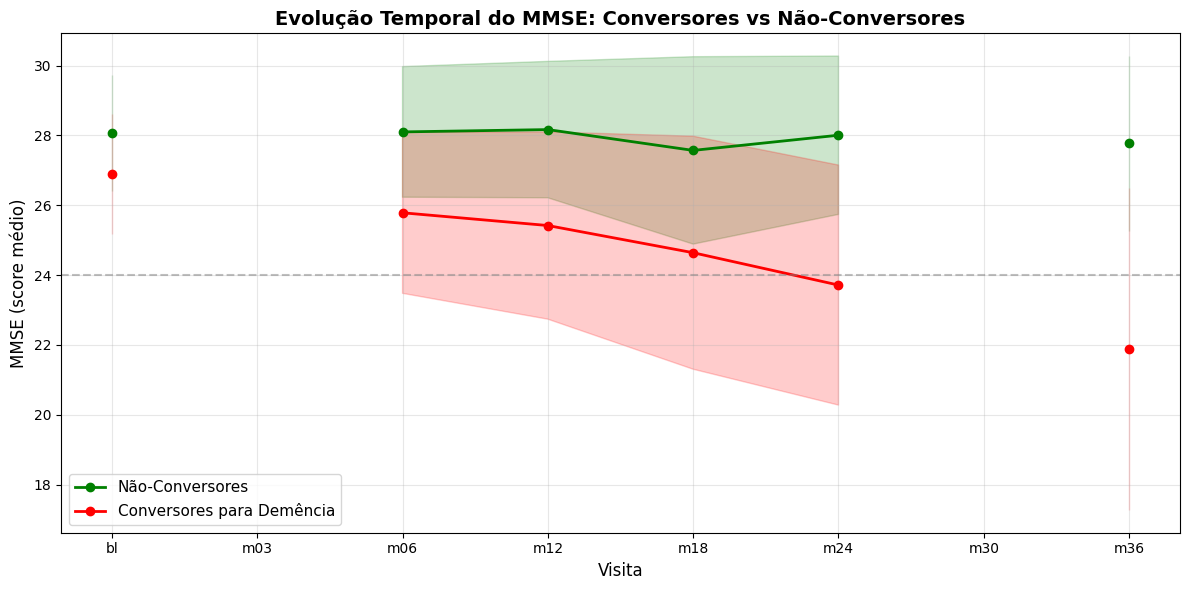

In [890]:
mmse_data = data_clinical_filtered[['rid', 'viscode', 'mmse', 'converteu_3anos']].dropna(subset=['mmse'])

mmse_trajectory = mmse_data.groupby(['viscode', 'converteu_3anos'])['mmse'].agg(['mean', 'std', 'count']).reset_index()

print("Trajetória temporal de MMSE:")
print(mmse_trajectory.pivot(index='viscode', columns='converteu_3anos', values='mean'))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

visit_order = ["bl","m03","m06","m12","m18","m24","m30","m36"]

for conversion in ['NAO', 'SIM']:
    data_group = mmse_trajectory[mmse_trajectory['converteu_3anos'] == conversion]
    data_group = data_group.set_index('viscode').reindex(visit_order).reset_index()
    
    label = 'Não-Conversores' if conversion == 'NAO' else 'Conversores para Demência'
    color = 'green' if conversion == 'NAO' else 'red'
    
    plt.plot(data_group['viscode'], data_group['mean'], marker='o', linewidth=2, 
             label=label, color=color)
    plt.fill_between(range(len(data_group)), 
                     data_group['mean'] - data_group['std'], 
                     data_group['mean'] + data_group['std'], 
                     alpha=0.2, color=color)

plt.xlabel('Visita', fontsize=12)
plt.ylabel('MMSE (score médio)', fontsize=12)
plt.title('Evolução Temporal do MMSE: Conversores vs Não-Conversores', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=24, color='gray', linestyle='--', alpha=0.5, label='Limiar demência (24)')
plt.tight_layout()
plt.show()


ADAS é um teste específico de disfunção cognitiva em Alzheimer (quanto maior o score, pior a cognição).

Trajetória temporal de ADAS13:
converteu_3anos        NAO        SIM
viscode                              
bl               13.584383  20.945759
m06              13.101234  22.507831
m12              12.771061  23.393777
m18              15.606567  25.862719
m24              13.461360  27.196885
m36              14.036253  30.945114


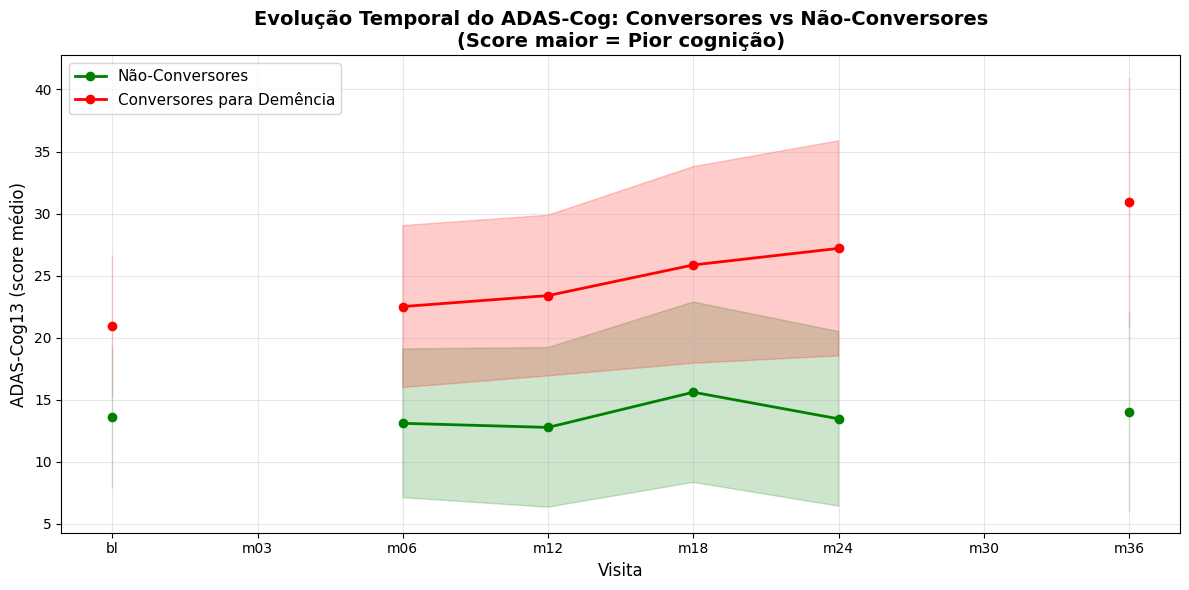

In [891]:
adas_data = data_clinical_filtered[['rid', 'viscode', 'adas13', 'converteu_3anos']].dropna(subset=['adas13'])

adas_trajectory = adas_data.groupby(['viscode', 'converteu_3anos'])['adas13'].agg(['mean', 'std', 'count']).reset_index()

print("Trajetória temporal de ADAS13:")
print(adas_trajectory.pivot(index='viscode', columns='converteu_3anos', values='mean'))

plt.figure(figsize=(12, 6))

visit_order = ["bl","m03","m06","m12","m18","m24","m30","m36"]

for conversion in ['NAO', 'SIM']:
    data_group = adas_trajectory[adas_trajectory['converteu_3anos'] == conversion]
    data_group = data_group.set_index('viscode').reindex(visit_order).reset_index()
    
    label = 'Não-Conversores' if conversion == 'NAO' else 'Conversores para Demência'
    color = 'green' if conversion == 'NAO' else 'red'
    
    plt.plot(data_group['viscode'], data_group['mean'], marker='o', linewidth=2, 
             label=label, color=color)
    plt.fill_between(range(len(data_group)), 
                     data_group['mean'] - data_group['std'], 
                     data_group['mean'] + data_group['std'], 
                     alpha=0.2, color=color)

plt.xlabel('Visita', fontsize=12)
plt.ylabel('ADAS-Cog13 (score médio)', fontsize=12)
plt.title('Evolução Temporal do ADAS-Cog: Conversores vs Não-Conversores\n(Score maior = Pior cognição)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Análise de volumes cerebrais: Hipocampo

O hipocampo é crítico para memória e atrofia precocemente no Alzheimer.

Trajetória temporal do Volume Hipocampal:
converteu_3anos          NAO          SIM
viscode                                  
bl               7182.641618  6250.748428
m03              7352.946188  6421.084746
m06              7156.699387  6093.391892
m12              7108.258359  6006.600000
m18              6657.031579  5846.500000
m24              6993.951613  5887.577778
m36              6874.140127  5642.382716


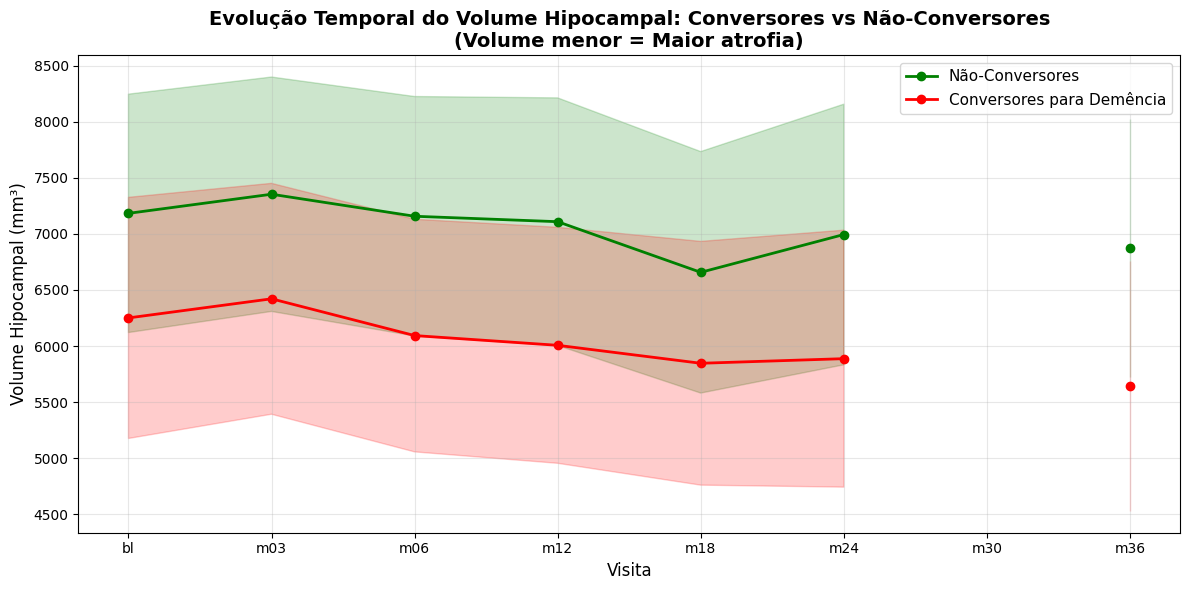

In [892]:
hippo_data = data_clinical_filtered[['rid', 'viscode', 'hippocampus', 'converteu_3anos']].dropna(subset=['hippocampus'])

hippo_trajectory = hippo_data.groupby(['viscode', 'converteu_3anos'])['hippocampus'].agg(['mean', 'std', 'count']).reset_index()

print("Trajetória temporal do Volume Hipocampal:")
print(hippo_trajectory.pivot(index='viscode', columns='converteu_3anos', values='mean'))

plt.figure(figsize=(12, 6))

visit_order = ["bl","m03","m06","m12","m18","m24","m30","m36"]

for conversion in ['NAO', 'SIM']:
    data_group = hippo_trajectory[hippo_trajectory['converteu_3anos'] == conversion]
    data_group = data_group.set_index('viscode').reindex(visit_order).reset_index()
    
    label = 'Não-Conversores' if conversion == 'NAO' else 'Conversores para Demência'
    color = 'green' if conversion == 'NAO' else 'red'
    
    plt.plot(data_group['viscode'], data_group['mean'], marker='o', linewidth=2, 
             label=label, color=color)
    plt.fill_between(range(len(data_group)), 
                     data_group['mean'] - data_group['std'], 
                     data_group['mean'] + data_group['std'], 
                     alpha=0.2, color=color)

plt.xlabel('Visita', fontsize=12)
plt.ylabel('Volume Hipocampal (mm³)', fontsize=12)
plt.title('Evolução Temporal do Volume Hipocampal: Conversores vs Não-Conversores\n(Volume menor = Maior atrofia)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Visualizar diferenças entre grupos em múltiplas variáveis clínicas simultaneamente.

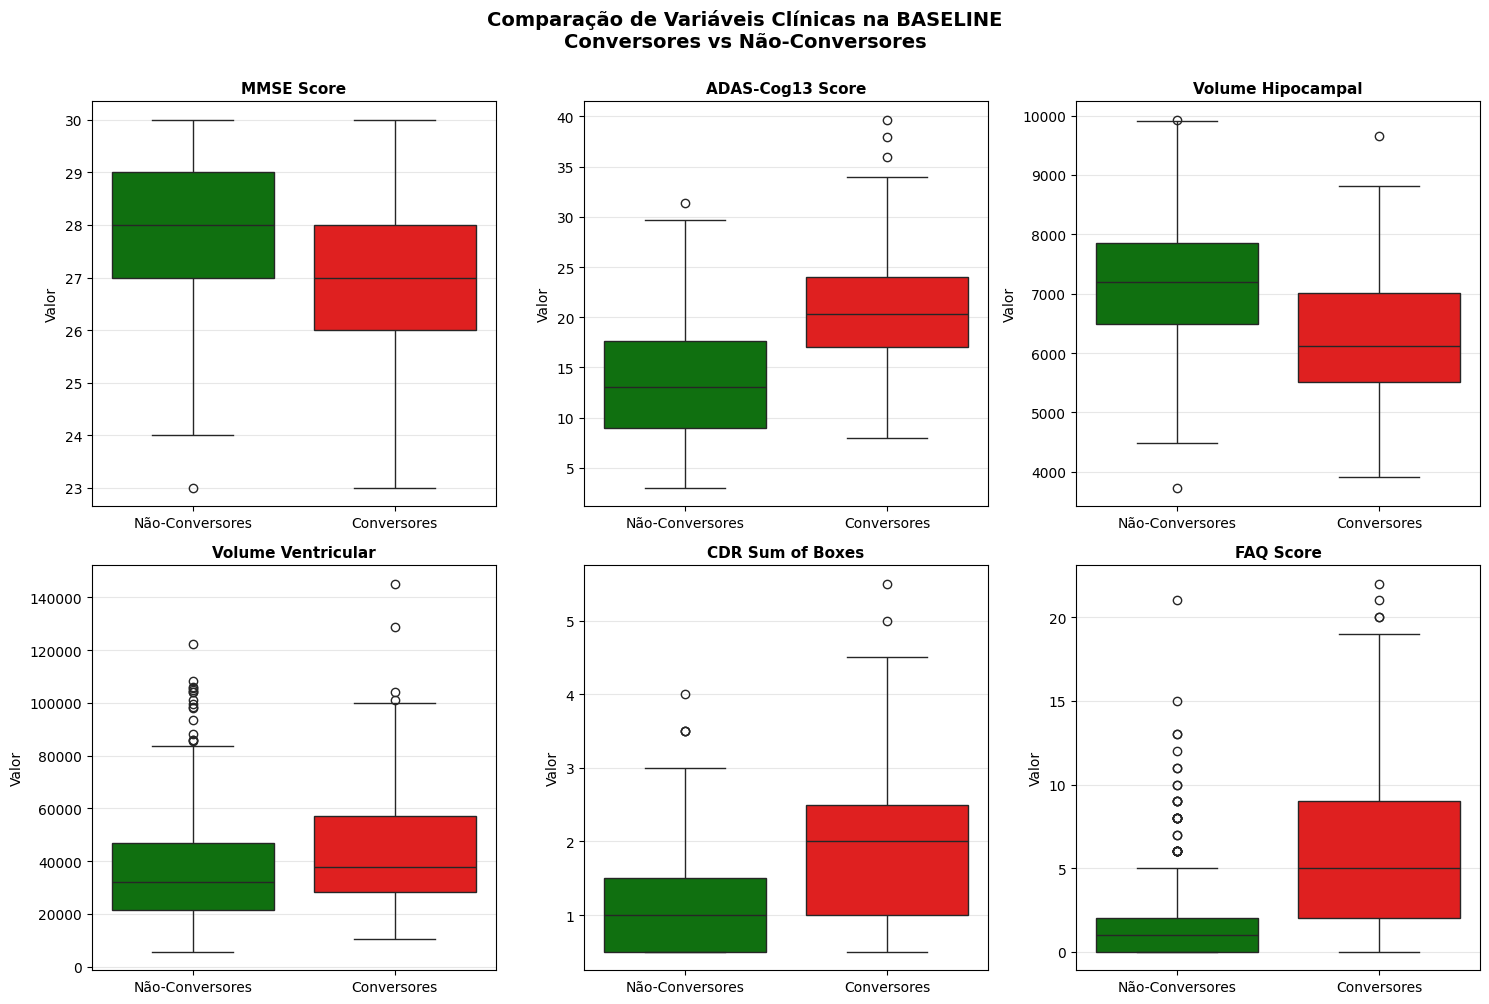

In [893]:
baseline_data = data_clinical_filtered[data_clinical_filtered['viscode'] == 'bl'].copy()

vars_to_plot = [
    ('mmse', 'MMSE Score'),
    ('adas13', 'ADAS-Cog13 Score'),
    ('hippocampus', 'Volume Hipocampal'),
    ('ventricles', 'Volume Ventricular'),
    ('cdrsb', 'CDR Sum of Boxes'),
    ('faq', 'FAQ Score')
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (var, title) in enumerate(vars_to_plot):
    if var in baseline_data.columns:
        data_to_plot = baseline_data[[var, 'converteu_3anos']].dropna()
        
        if len(data_to_plot) > 0:
            data_to_plot['conversion_label'] = data_to_plot['converteu_3anos'].map({
                'NAO': 'Não-Conversores',
                'SIM': 'Conversores'
            })
            
            sns.boxplot(data=data_to_plot, x='conversion_label', y=var, 
                       hue='conversion_label', palette=['green', 'red'], 
                       ax=axes[idx], legend=False)
            axes[idx].set_title(title, fontweight='bold', fontsize=11)
            axes[idx].set_xlabel('')
            axes[idx].set_ylabel('Valor', fontsize=10)
            axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Comparação de Variáveis Clínicas na BASELINE\nConversores vs Não-Conversores', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


Calcular a mudança (piora ou melhora) de cada paciente entre baseline e 36 meses.

In [894]:
baseline = data_clinical_filtered[data_clinical_filtered['viscode'] == 'bl'].set_index('rid')
m36 = data_clinical_filtered[data_clinical_filtered['viscode'] == 'm36'].set_index('rid')

delta_vars = ['mmse', 'adas13', 'hippocampus', 'ventricles', 'cdrsb']

delta_data = pd.DataFrame()
delta_data['converteu_3anos'] = baseline['converteu_3anos']

for var in delta_vars:
    if var in baseline.columns and var in m36.columns:
        delta_data[f'delta_{var}'] = m36[var] - baseline[var]

delta_data = delta_data.dropna(how='all', subset=[col for col in delta_data.columns if col.startswith('delta_')])

print(f"Pacientes com dados de mudança: {len(delta_data)}")
print(f"\nDistribuição:")
print(delta_data['converteu_3anos'].value_counts())
print("Mudança média (Δ) entre baseline e m36:")

for var in delta_vars:
    col = f'delta_{var}'
    if col in delta_data.columns:
        converters = delta_data[delta_data['converteu_3anos'] == 'SIM'][col].dropna()
        non_converters = delta_data[delta_data['converteu_3anos'] == 'NAO'][col].dropna()
        
        if len(converters) > 0 and len(non_converters) > 0:
            print(f"{var.upper()}:")
            print(f"  Conversores:     Δ={converters.mean():.2f} (DP={converters.std():.2f})")
            print(f"  Não-Conversores: Δ={non_converters.mean():.2f} (DP={non_converters.std():.2f})")
            diff = converters.mean() - non_converters.mean()
            print(f"  Diferença: {diff:+.2f}\n")

Pacientes com dados de mudança: 588

Distribuição:
converteu_3anos
NAO    397
SIM    191
Name: count, dtype: int64
Mudança média (Δ) entre baseline e m36:
MMSE:
  Conversores:     Δ=-5.03 (DP=4.24)
  Não-Conversores: Δ=-0.32 (DP=2.32)
  Diferença: -4.72

ADAS13:
  Conversores:     Δ=10.43 (DP=8.36)
  Não-Conversores: Δ=0.55 (DP=6.12)
  Diferença: +9.88

HIPPOCAMPUS:
  Conversores:     Δ=-683.30 (DP=374.30)
  Não-Conversores: Δ=-332.24 (DP=341.42)
  Diferença: -351.06

VENTRICLES:
  Conversores:     Δ=12553.73 (DP=7230.68)
  Não-Conversores: Δ=5885.52 (DP=4690.10)
  Diferença: +6668.21

CDRSB:
  Conversores:     Δ=3.88 (DP=2.85)
  Não-Conversores: Δ=0.21 (DP=1.22)
  Diferença: +3.67



## 9. Visualizar mudanças individuais entre baseline e m36

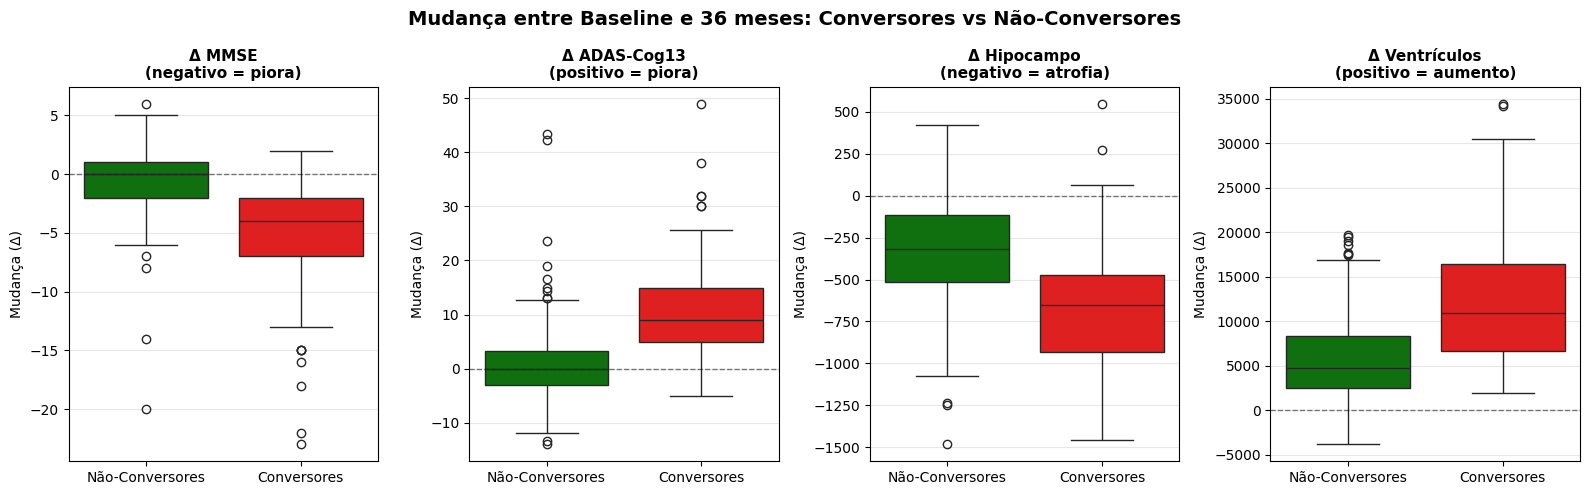

In [895]:
vars_to_plot_delta = [
    ('delta_mmse', 'Δ MMSE\n(negativo = piora)'),
    ('delta_adas13', 'Δ ADAS-Cog13\n(positivo = piora)'),
    ('delta_hippocampus', 'Δ Hipocampo\n(negativo = atrofia)'),
    ('delta_ventricles', 'Δ Ventrículos\n(positivo = aumento)')
]

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for idx, (var, title) in enumerate(vars_to_plot_delta):
    if var in delta_data.columns:
        data_to_plot = delta_data[[var, 'converteu_3anos']].dropna()
        
        if len(data_to_plot) > 0:
            data_to_plot['conversion_label'] = data_to_plot['converteu_3anos'].map({
                'NAO': 'Não-Conversores',
                'SIM': 'Conversores'
            })
            
            sns.boxplot(data=data_to_plot, x='conversion_label', y=var, 
                       hue='conversion_label', palette=['green', 'red'], 
                       ax=axes[idx], legend=False)
            axes[idx].set_title(title, fontweight='bold', fontsize=11)
            axes[idx].set_xlabel('')
            axes[idx].set_ylabel('Mudança (Δ)', fontsize=10)
            axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
            axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Mudança entre Baseline e 36 meses: Conversores vs Não-Conversores', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Resumo dos achados

### Principais mudanças observadas nos conversores para demência:

In [896]:
print("RESUMO DA ANÁLISE TEMPORAL: O QUE MUDOU NOS CONVERSORES?")
print("""
Esta análise exploratória revelou as principais mudanças que ocorrem em pacientes 
com MCI que convertem para demência nos 3 anos de acompanhamento:

1. TESTES COGNITIVOS:
   - MMSE: Declínio mais acentuado nos conversores (queda progressiva)
   - ADAS-Cog: Aumento mais rápido nos conversores (piora cognitiva)
   - Os conversores já apresentam scores piores na baseline

2. VOLUMES CEREBRAIS:
   - Hipocampo: Atrofia mais acelerada nos conversores
   - Ventrículos: Expansão maior nos conversores (compensando atrofia)
   - Diferenças já visíveis na baseline (volumes menores)

3. TRAJETÓRIA TEMPORAL:
   - Conversores mostram declínio progressivo e consistente
   - Não-conversores mantêm relativa estabilidade
   - Maior taxa de mudança (Δ) nos conversores entre bl e m36

4. VARIÁVEIS DISCRIMINATIVAS NA BASELINE:
   - Cognição (MMSE, ADAS)
   - Estrutura cerebral (hipocampo, ventrículos)
   - Funcionalidade (FAQ, CDR-SB)

CONCLUSÃO: Conversores apresentam pior estado cognitivo e estrutural já na baseline,
com declínio acelerado ao longo do tempo. Essas mudanças são detectáveis e podem
ser usadas para construir modelos preditivos de conversão para demência.
""")


RESUMO DA ANÁLISE TEMPORAL: O QUE MUDOU NOS CONVERSORES?

Esta análise exploratória revelou as principais mudanças que ocorrem em pacientes 
com MCI que convertem para demência nos 3 anos de acompanhamento:

1. TESTES COGNITIVOS:
   - MMSE: Declínio mais acentuado nos conversores (queda progressiva)
   - ADAS-Cog: Aumento mais rápido nos conversores (piora cognitiva)
   - Os conversores já apresentam scores piores na baseline

2. VOLUMES CEREBRAIS:
   - Hipocampo: Atrofia mais acelerada nos conversores
   - Ventrículos: Expansão maior nos conversores (compensando atrofia)
   - Diferenças já visíveis na baseline (volumes menores)

3. TRAJETÓRIA TEMPORAL:
   - Conversores mostram declínio progressivo e consistente
   - Não-conversores mantêm relativa estabilidade
   - Maior taxa de mudança (Δ) nos conversores entre bl e m36

4. VARIÁVEIS DISCRIMINATIVAS NA BASELINE:
   - Cognição (MMSE, ADAS)
   - Estrutura cerebral (hipocampo, ventrículos)
   - Funcionalidade (FAQ, CDR-SB)

CONCLUSÃO: C


Comparar as distribuições de variáveis importantes entre CN, MCI e Dementia na baseline para entender a sobreposição entre os grupos.

In [897]:
baseline_all_dx = data_full[data_full['viscode'] == 'bl'].copy()

print("Distribuição de diagnósticos na baseline: ", baseline_all_dx['dx'].value_counts() , )
print(f"\nTotal de pacientes: {baseline_all_dx['rid'].nunique()}")

Distribuição de diagnósticos na baseline:  dx
MCI         1101
CN           895
Dementia     413
Name: count, dtype: int64

Total de pacientes: 2430


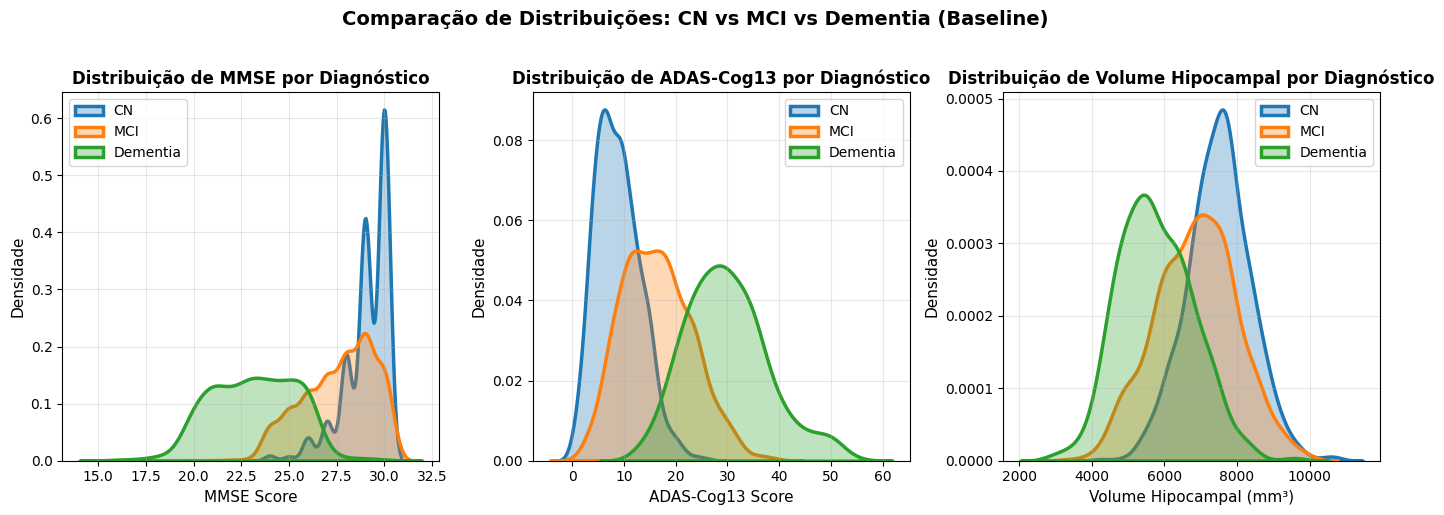

In [898]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
for dx_group in ['CN', 'MCI', 'Dementia']:
    data_group = baseline_all_dx[baseline_all_dx['dx'] == dx_group]['mmse'].dropna()
    if len(data_group) > 0:
        sns.kdeplot(data_group, label=dx_group, linewidth=2.5, fill=True, alpha=0.3)

plt.xlabel('MMSE Score', fontsize=11)
plt.ylabel('Densidade', fontsize=11)
plt.title('Distribuição de MMSE por Diagnóstico', fontweight='bold', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
for dx_group in ['CN', 'MCI', 'Dementia']:
    data_group = baseline_all_dx[baseline_all_dx['dx'] == dx_group]['adas13'].dropna()
    if len(data_group) > 0:
        sns.kdeplot(data_group, label=dx_group, linewidth=2.5, fill=True, alpha=0.3)

plt.xlabel('ADAS-Cog13 Score', fontsize=11)
plt.ylabel('Densidade', fontsize=11)
plt.title('Distribuição de ADAS-Cog13 por Diagnóstico', fontweight='bold', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
for dx_group in ['CN', 'MCI', 'Dementia']:
    data_group = baseline_all_dx[baseline_all_dx['dx'] == dx_group]['hippocampus'].dropna()
    if len(data_group) > 0:
        sns.kdeplot(data_group, label=dx_group, linewidth=2.5, fill=True, alpha=0.3)

plt.xlabel('Volume Hipocampal (mm³)', fontsize=11)
plt.ylabel('Densidade', fontsize=11)
plt.title('Distribuição de Volume Hipocampal por Diagnóstico', fontweight='bold', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.suptitle('Comparação de Distribuições: CN vs MCI vs Dementia (Baseline)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [899]:
print("ESTATÍSTICAS DESCRITIVAS POR GRUPO DIAGNÓSTICO (BASELINE)")

vars_compare = ['mmse', 'adas13', 'hippocampus', 'ventricles', 'age']

for var in vars_compare:
    if var in baseline_all_dx.columns:
        print(f"\n{var.upper()}:")
        for dx_group in ['CN', 'MCI', 'Dementia']:
            data_group = baseline_all_dx[baseline_all_dx['dx'] == dx_group][var].dropna()
            if len(data_group) > 0:
                print(f"  {dx_group:8} - Média: {data_group.mean():6.2f}, DP: {data_group.std():5.2f}, N: {len(data_group):4}")

print("- CN (Cognitively Normal): Controles saudáveis")
print("- MCI (Mild Cognitive Impairment): Comprometimento cognitivo leve")
print("- Dementia: Pacientes com demência (estágio avançado)")


ESTATÍSTICAS DESCRITIVAS POR GRUPO DIAGNÓSTICO (BASELINE)

MMSE:
  CN       - Média:  29.07, DP:  1.15, N:  894
  MCI      - Média:  27.60, DP:  1.87, N: 1101
  Dementia - Média:  23.17, DP:  2.20, N:  413

ADAS13:
  CN       - Média:   8.83, DP:  4.36, N:  891
  MCI      - Média:  16.35, DP:  6.74, N: 1095
  Dementia - Média:  29.86, DP:  8.01, N:  405

HIPPOCAMPUS:
  CN       - Média: 7492.09, DP: 881.09, N:  800
  MCI      - Média: 6864.52, DP: 1124.67, N:  928
  Dementia - Média: 5761.85, DP: 1023.54, N:  338

VENTRICLES:
  CN       - Média: 32716.31, DP: 18131.81, N:  825
  MCI      - Média: 40327.88, DP: 22439.73, N: 1029
  Dementia - Média: 50425.99, DP: 25031.91, N:  383

AGE:
  CN       - Média:  72.23, DP:  6.66, N:  894
  MCI      - Média:  72.80, DP:  7.58, N: 1098
  Dementia - Média:  74.74, DP:  7.90, N:  413
- CN (Cognitively Normal): Controles saudáveis
- MCI (Mild Cognitive Impairment): Comprometimento cognitivo leve
- Dementia: Pacientes com demência (estágio avançado